# Figure 8: Spatial and temporal tuning of model

In [1]:
from setup_nb import *

In [2]:
from detector.implementations import TwoQ, FourQ, lowpass, FourQDelay
from detector.stimulus import FastDiscretePhi, fast_discrete_phi

### Simulations

#### Parameters

In [3]:
dt = 0.001  # in s

lam = 90.0
duration = 10.0
start = 0.5
stop = 9.5

contrast = 0.25
offset = 1.3

recfield = 240.0
delta_phi = 4.0

param_velo = np.logspace(0, 3, base=10, num=20)  # in deg/s

param_offsets = np.linspace(2, 5, num=10)
param_contrasts = np.linspace(0, 2, num=15)

#### Detectors

In [4]:
tau_hp = 0.25
tau_lp = 0.05

d_2q_dc = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), dt=dt)

d_t4 = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), pathway_weights=(1.0, 0.0), dt=dt)
d_t5 = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), pathway_weights=(0.0, 1.0), dt=dt)

d_4q = FourQ(tau_hp=tau_hp, tau_lp=tau_lp, dc=0.0, dt=dt)

#### Run

In [5]:
def run(detector, flip, lam=lam):
        
    sys.stdout.write("\n"); sys.stdout.flush()
    
    c = []
    for velo in param_velo:
        stim = FastDiscretePhi(lam=lam, duration=duration, start=start, stop=stop, nd=False,
                               flip=flip, vel=velo).render(recfield, delta_phi, dt)
        stim = np.maximum(contrast * stim + offset, 0)
        
        output = detector.detect(stim)
        c.append(output.mean())
        sys.stdout.write("."); sys.stdout.flush()
        
    c = np.array(c)
    return np.array(c)

In [6]:
phi_30 = run(d_2q_dc, False, 30.0)
rphi_30 = run(d_2q_dc, True, 30.0)

phi_60 = run(d_2q_dc, False, 60.0)
rphi_60 = run(d_2q_dc, True, 60.0)

phi_90 = run(d_2q_dc, False, 90.0)
rphi_90 = run(d_2q_dc, True, 90.0)


....................
....................
....................
....................
....................
....................

### Panels

In [7]:
def panel_trace(fm1, fm2, rphi, ax, legend=False):
    
    d = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), dt=0.001)
    
    base_args = {
        "duration": 5.0,
        "start": 1.0,
        "stop": 4.0,
        "lam": 90.0,
        "jump_width": 4.0,
        "phase_motion": 1.0,
        "phase_flicker": 1.0,
        "recfield": 240.0,
        "delta_phi": 4.0,
        "dt": 0.001,
    }
    
    contrast = 0.25
    offset = 1.3
    
    ff1 = fm1 if rphi else 0.0
    ff2 = fm2 if rphi else 0.0
        
    stim1 = fast_discrete_phi(f_motion=fm1, f_flicker=ff1, **base_args)
    stim1 = np.maximum(contrast * stim1 + offset, 0)
    
    stim2 = fast_discrete_phi(f_motion=fm2, f_flicker=ff2, **base_args)
    stim2 = np.maximum(contrast * stim2 + offset, 0)
    
    r1 = d.detect(stim1).sum(axis=0)
    r2 = d.detect(stim2).sum(axis=0)

    tau = 0.2
    r1, r2 = lowpass(r1[np.newaxis, :], tau, 0.001).squeeze(), lowpass(r2[np.newaxis, :], tau, 0.001).squeeze()
    
    m = np.max([np.abs(r1).max(), np.abs(r2).max()])
    
    r1, r2 = r1 / m, r2 / m
    
    # Plotting
    
    t = np.arange(stim1.shape[1]) * 0.001
    ax.plot(t, r1, color="black", label=u"{0} °/s".format(int(4.0 * fm1)))
    ax.plot(t, r2, color="red", label=u"{0} °/s".format(int(4.0 * fm2)))
    
    ax.axvspan(1.0, 4.0, edgecolor='none', facecolor='gray', zorder=0, alpha=0.075)
    
    ax.set_xlim([0.0, 5.0])
    ax.set_ylim([-1.1, 1.1])
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_yticks([-1, 0, 1])
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Normalized\nresponse (a.u.)")
    
    add_refline(ax, horizontal=True)
    if legend:
        ax.legend(loc=(0.1, 0.05))
    
    sb.despine(ax=ax)

In [8]:
def panel_summary_lambda(l30, l60, l90, ax, legend=False):
    
    m = np.max([np.abs(l30).max(), np.abs(l60).max(), np.abs(l90).max()])
    l30, l60, l90 = l30 / m, l60 / m, l90 / m
    
    lw = 1.0
    ax.plot(param_velo, l30, color=gt_colors[30.0], label=u"λ = 30°", linewidth=lw)
    ax.plot(param_velo, l60, color=gt_colors[60.0], label=u"λ = 60°", linewidth=lw)
    ax.plot(param_velo, l90, color=gt_colors[90.0], label=u"λ = 90°", linewidth=lw)

    ax.set_xscale('log')
    ax.set_xlim([param_velo[0], param_velo[-1]])
    ax.set_xticks([1, 10, 100, 1000])
    ax.set_ylim([-1.2, 1.2])
    ax.set_yticks([-1.0, 0, 1.0])
    ax.set_ylabel("Normalized mean\nresponse (a.u.)", labelpad=2.5)
    ax.set_xlabel(u"Pattern speed (°/s)", labelpad=3.0)
    
    ax.tick_params(axis='both', which='major', pad=2)

    sb.plt.minorticks_off()
    
    if legend:
        ax.legend(loc=(0.1, 0.0))
    
    add_refline(ax, horizontal=True)
    
    sb.despine(ax=ax)

In [9]:
def model_figure():
        
    off = 1.5
    rows = [0, 2.7]
    panelsize = (2, 2)

    fig = sb.plt.figure(figsize=(2.7, 2.9))

    height = 4.7
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="a", nudge=0.5)
    panel_summary_lambda(phi_30, phi_60, phi_90, ax, legend=True)
    ax.set_title("Phi")
    
    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="b", nudge=0.1)
    panel_summary_lambda(rphi_30, rphi_60, rphi_90, ax)
    remove_axis(ax, y=True)
    ax.set_title("Reverse-phi")
    
    height = 1.2
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="c", nudge=0.5)
    panel_trace(16.0, 128.0, False, ax, True)
    
    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="d", nudge=0.1)
    panel_trace(16.0, 128.0, True, ax)
    remove_axis(ax, y=True)
    
    fig.set_frameon(False)
    fig.savefig("../output/Fig8.tif", format="tiff", dpi=standard_dpi)

### Plot

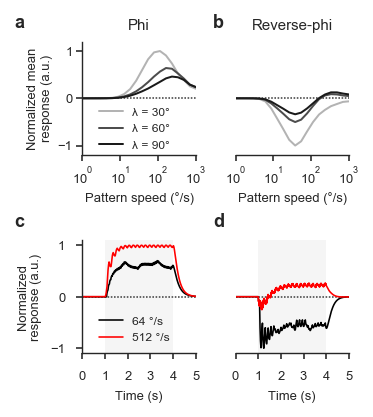

In [10]:
model_figure()